# Post-Up Rate EDA and Model
In this notebook, I will explore the relationships of different player stats and their future post-up rate.  

Goals:
- Look for what stats might best predict post-up rate.
- Find the best model to make accurate predictions.

Conclusions: 
- This is easier to predict accurately than post-up expected value.
- This is harder to improve on the baseline (player performance in the current year)
- While the predictions were more accurate for rate than performance, the small sample size still seems to be a problem.

## 0. Importing Libraries and Data

In [2]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['POST_TOUCHES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [5]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['POST_TOUCH_RATE'])

In [6]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_POST_TOUCH_RATE']]
X = data.drop(columns='TARGET_POST_TOUCH_RATE')

#### Splitting X and y into train, validate, and test sets

In [7]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'POST_TOUCH_RATE')

## 2. Determine Potential Features
- The most correlated features seem to be plays that came from the post (post shots, very closely guarded shots, etc.).
- Slower, bigger players tend to post-up.

#### Finding correlated features

In [8]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [9]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .5, 10)

In [10]:
# Looking at the most correlated features with the target
corr_features

['POST_TOUCH_FGA_PER_MIN_WEIGHTED',
 'POST_TOUCH_RATE_WEIGHTED',
 'POST_TOUCH_PTS_PER_MIN_WEIGHTED',
 'POST_TOUCH_FGM_PER_MIN_WEIGHTED',
 'POST_TOUCHES_PER_MIN_WEIGHTED',
 'POST_TOUCH_FGA_WEIGHTED',
 'POST_TOUCH_FGM_WEIGHTED',
 'POST_TOUCH_FGA_PER_MIN',
 'POST_TOUCH_PTS_WEIGHTED',
 'POST_TOUCH_RATE']

In [11]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_POST_TOUCH_RATE'], alpha=.5)

#### Graphing correlated features

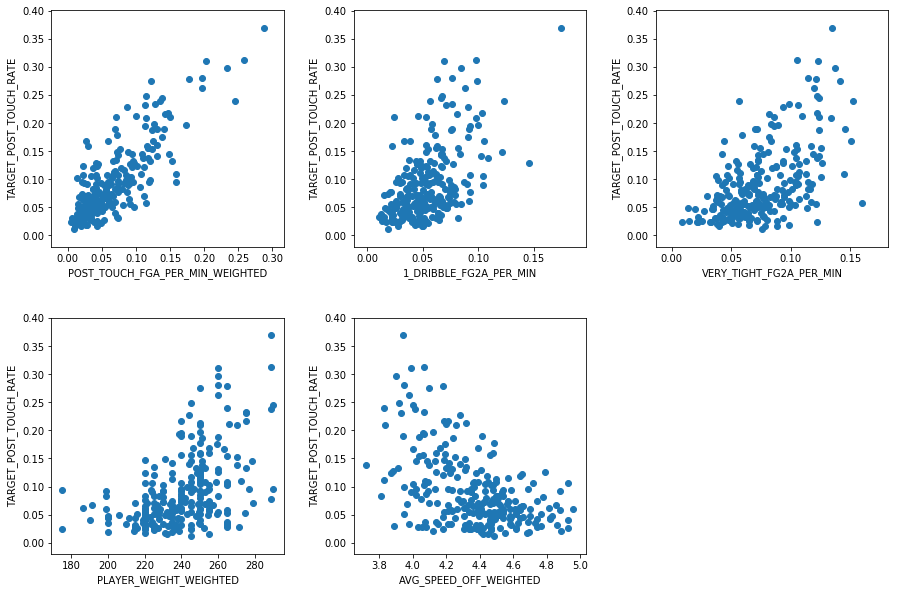

In [12]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

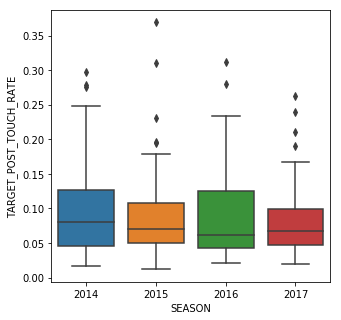

In [13]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

## 3. Modeling

#### RFECV
- Used 7 features (a few more than in the expected value for post-ups).

In [14]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

7

In [15]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['VERY_OPEN_FGA_FREQUENCY', 'VERY_OPEN_FG3A_FREQUENCY',
       '2_DRIBBLES_FGA_FREQUENCY', '2_DRIBBLES_FG2A_FREQUENCY',
       '2_DRIBBLES_FG3A_FREQUENCY', 'POST_TOUCH_FTM_PER_MIN',
       'POST_TOUCH_FTM_PER_MIN_WEIGHTED'],
      dtype='object')

In [16]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.4591952539043279

#### K BEST
- The 1 or 2 feature models seemed the best.
- As the features increased the model got worse.

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

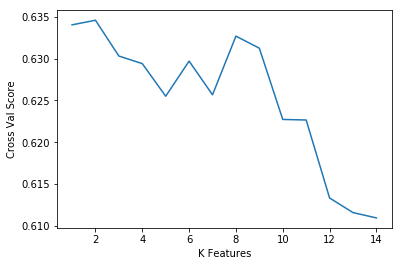

In [17]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 15):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1,15), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

1  Feature Cross Val Scores:  [0.4542142  0.81979261 0.72747983 0.45596425 0.71281545]
2  Feature Cross Val Scores:  [0.46041786 0.82833187 0.73524258 0.45611334 0.69291267]
3  Feature Cross Val Scores:  [0.46402097 0.83026517 0.738271   0.42275828 0.69627481]
4  Feature Cross Val Scores:  [0.46418472 0.83074207 0.73806917 0.41701046 0.69703913]
5  Feature Cross Val Scores:  [0.46286533 0.8157381  0.73721235 0.41641966 0.69528603]
6  Feature Cross Val Scores:  [0.47741944 0.81008393 0.74736509 0.40681166 0.70686577]
7  Feature Cross Val Scores:  [0.47411162 0.80684441 0.74751495 0.40621569 0.69368953]
8  Feature Cross Val Scores:  [0.49179626 0.78268091 0.74670624 0.42718446 0.71514209]


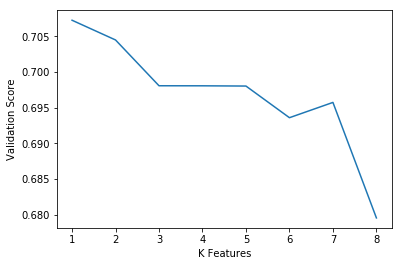

In [18]:
# Checking out 1 - 8 features
k_scores = []
for k in range(1, 9):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 9), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [19]:
# Printing out the scores with 2 features
k_best = SelectKBest(f_regression, k=2)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.7044897419286693

In [20]:
# Printing the model features
model_features

['POST_TOUCH_RATE_WEIGHTED', 'POST_TOUCH_FGA_PER_MIN_WEIGHTED']

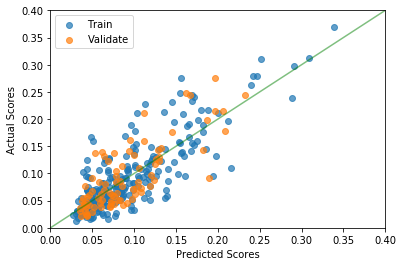

In [21]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### PCA
- The model does reasonably well, but one of the folds really struggled more than the others.
- 2 features were chosen using the elbow method.

In [22]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.29744777, 0.17033575, 0.07051126, 0.05115521, 0.04074574,
       0.02998744, 0.02637841, 0.02481237, 0.01965087, 0.01871216,
       0.01464643, 0.01349416, 0.0115157 , 0.01038769, 0.00947872])

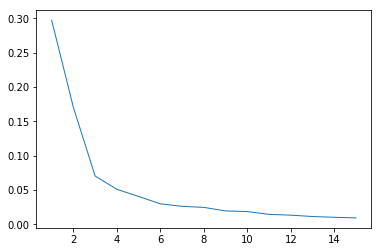

In [23]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [24]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.47995401, 0.42039545, 0.48522636, 0.07056377, 0.50010995])

In [25]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.44136285786334756

#### Neural Net
- Performed much worse than other models.
- The graph has some weird patterns.

In [26]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [27]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [28]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [29]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

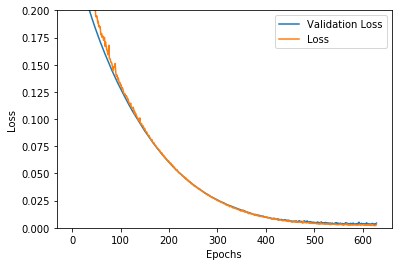

In [30]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [31]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.14808982976558782

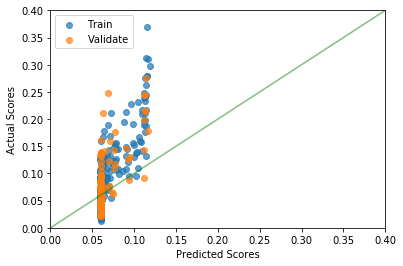

In [32]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the better models.

In [36]:
# Saving the model features
model_features = ['POST_TOUCH_RATE_WEIGHTED', 'FTA_PER_MIN_WEIGHTED', 'POST_TOUCHES_PER_MIN_WEIGHTED',
                  'POST_TOUCH_FGA_PCT', 'POST_TOUCH_FGA_PCT', 'POST_TOUCH_TOV_PCT_WEIGHTED',
                  'CATCH_SHOOT_RATE_WEIGHTED', 'DRIVE_RATE_WEIGHTED', 'PULL_UP_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES',
                  'SKINNY', 'AGE', '2015', '2016', '2017', ]

In [37]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.42832035, 0.81198349, 0.73116111, 0.45717312, 0.65590617])

In [38]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.710616073670269

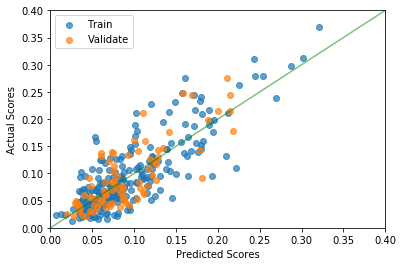

In [39]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are similar compared to the linear regression.
- The ridge scores are slightly better and its graph is very well balanced.
- The post-up rate and post-up touches were really important.

In [40]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [41]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.4398991 , 0.81246067, 0.73350644, 0.45980378, 0.66106391])

In [42]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.7070222849081365

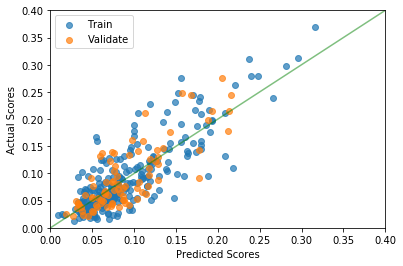

In [43]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=.4)

In [44]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.49220225, 0.72771606, 0.70404735, 0.41480439, 0.67118314])

In [45]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.6507635227326802

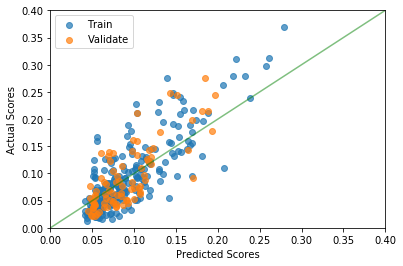

In [46]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=.4)

In [47]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
POST_TOUCH_RATE_WEIGHTED,0.04403,0.026091
FTA_PER_MIN_WEIGHTED,0.00000,0.001305
POST_TOUCHES_PER_MIN_WEIGHTED,0.00000,0.023534
POST_TOUCH_FGA_PCT,0.00000,0.002611
POST_TOUCH_FGA_PCT,0.00000,0.002611
POST_TOUCH_TOV_PCT_WEIGHTED,-0.00000,-0.002240
CATCH_SHOOT_RATE_WEIGHTED,0.00000,0.002333
DRIVE_RATE_WEIGHTED,-0.00000,0.003300
PULL_UP_RATE_WEIGHTED,-0.00000,-0.004888
PLAYER_HEIGHT_INCHES,0.00000,0.003584


#### Final scores (Ridge)
- The r2 score on the test set was much worse than other models on the validation data, but there were folds in the cross-validation sets that did worse than the test score.
- There was a 3.6 percent decline in the rmse compared to the baseline using the test set.
- There was a 14.9 percent improvement in the rmse compared to the baseline for the validation data.

In [66]:
# Ridge score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.5775923031808914

In [67]:
# Root mean squared error (test set)
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.04586684329141822

In [68]:
# The score if the prediction was just the value from the current year (test set)
baseline = mean_squared_error(y_test, X_test['POST_TOUCH_RATE']) ** .5
baseline

0.04428368312074574

In [69]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

-0.03575041774090404

In [72]:
# Root mean squared error (validation data)
rmse = mean_squared_error(y_validate, ridge.predict(X_validate_scaled)) ** .5
rmse

0.03697591909757609

In [73]:
# The score if the prediction was just the value from the current year
baseline = mean_squared_error(y_validate, X_validate['POST_TOUCH_RATE']) ** .5
baseline

0.043433279200613094

In [74]:
# Percent improvement (validations)
1 - rmse/baseline

0.14867309634189108

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [75]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_POST_TOUCH_RATE'] = ridge.predict(X_train_scaled)

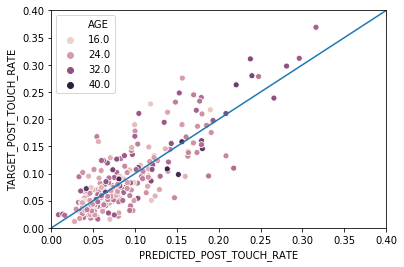

In [76]:
sns.scatterplot('PREDICTED_POST_TOUCH_RATE', 'TARGET_POST_TOUCH_RATE', data=train, hue='AGE')
plt.plot([0,.4], [0,.4])
plt.xlim(0, .4)
plt.ylim(0, .4);

#### Saving the predictions

In [98]:
# Loading the target dataframe
target_df = pd.read_csv('./data/target_df', index_col=0)

In [99]:
# Adding the predictions to the target dataframe
master_scaled = scaler.transform(master_df[model_features].dropna())
predictions = ridge.predict(master_scaled)
predictions_index = master_df[model_features].dropna().index
predictions_df = pd.DataFrame(predictions, columns=['PRED_POST_TOUCH_RATE'], index=predictions_index)
target_df = pd.merge(target_df, predictions_df, how='left', left_index=True, right_index=True)

In [100]:
# Saving the dataframe
target_df.to_csv('./data/target_df')